In [ ]:
import matplotlib.pyplot as plt
import torch
from torch import nn  # All neural network modules
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch.utils.data import Dataset, DataLoader, random_split  # Gives easier dataset managment
# from torch.utils.data.sampler import random_split
import torchvision
import torchvision.datasets as datasets  # Standard datasets
import torchvision.transforms as transforms

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
#The MNIST dataset contains black and white, hand-written (numerical) digits that are 28x28 pixels large. 
train_dataset = datasets.CIFAR10(root="dataset/", train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.CIFAR10(root="dataset/", train=False, transform=transforms.ToTensor(), download=True)
# root is the path where the train/test data is stored,
#train specifies training or test dataset,
#download=True downloads the data from the internet if it’s not available at root.
#transform specify the feature and label transformations. ToTensor converts a PIL image or NumPy ndarray into a FloatTensor and scales the image’s pixel intensity values in the range [0., 1.]

100%|██████████| 170498071/170498071 [00:03<00:00, 43827105.29it/s]


Extracting dataset/cifar-10-python.tar.gz to dataset/
Files already downloaded and verified


In [ ]:
print(len(train_dataset)) 
print(len(test_dataset)) 

50000
10000


In [ ]:
labels_map = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}

<ipython-input-6-7c4e955bccb5>:9: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3571.)
  plt.imshow(img.T)


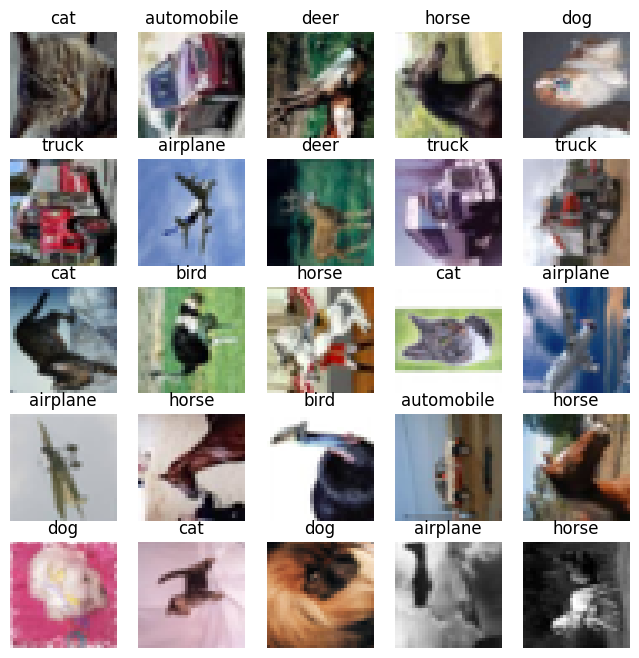

In [ ]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 5,5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.T)
plt.show()

In [ ]:
# Define relevant variables 
batch_size = 64
num_classes = 10
learning_rate = 0.1
num_epochs = 10

In [ ]:
# Making dataset iterable
import numpy as np

num_samples = len(train_dataset)
frac = 0.1
num_subset_samples = int(num_samples * frac)

torch.manual_seed(0) # set random seed for reproducibility
subset_indices, _ = random_split(train_dataset, [num_subset_samples, num_samples - num_subset_samples])

# Create a dataloader using the random sampler
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)

In [ ]:
# Creating a CNN class
class ConvNeuralNet(nn.Module):
	#  Determine what layers and their order in CNN object 
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
    
    # Progresses data across layers    
    def forward(self, xb):
      return self.network(xb)

In [ ]:
model = ConvNeuralNet(num_classes).to(device)
# Set Loss function with criterion
criterion = nn.CrossEntropyLoss()

# Set optimizer with optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
model

ConvNeuralNet(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_featur

Part a

In [ ]:
# We use the pre-defined number of epochs to determine how many iterations to train the network on
for epoch in range(num_epochs):
	#Load in the data in batches using the train_loader object
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))          

Epoch [1/10], Loss: 2.3148
Epoch [2/10], Loss: 2.2001
Epoch [3/10], Loss: 2.0447
Epoch [4/10], Loss: 2.1888
Epoch [5/10], Loss: 1.7662
Epoch [6/10], Loss: 1.0853
Epoch [7/10], Loss: 0.7316
Epoch [8/10], Loss: 0.2846
Epoch [9/10], Loss: 0.1758
Epoch [10/10], Loss: 0.0549


Part b

In [ ]:
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
def train_model(epochs, dataloader, device, model, optimizer, loss_function):
    # Set model to training mode in order to unfreeze all layers and allow gradient propagation
    model.train()
    # These two lists will be used to store average loss and accuracy for each epoch
    total_loss, acc = list(), list()
    # Now write out the training procedure
    for epoch in range(epochs):
        print("Epoch:", epoch+1)
        # Each batch produces a loss, predictions and target
        batch_loss, batch_preds, batch_target = 0, list(), list()
        # For each batch, train the model
        for x, y in tqdm(dataloader, total=len(dataloader)):
            # Make sure that data is on the same device as the model
            x, y = x.to(device), y.to(device)
            # Remove all previous gradients
            optimizer.zero_grad()
            # Get predictions by performing a forward pass
            preds = model.forward(x.float())
            # Calculate error
            loss = loss_function(preds, y.to(torch.int64))
            # Calculate all the gradients for each layer
            loss.backward()
            # Finall, update the weights
            optimizer.step()
            # Save the loss
            batch_loss+= loss.item()
            # Save the predictions and target
            batch_preds.extend(np.argmax(preds.cpu().detach().numpy(), axis=1))
            batch_target.extend(y.cpu().detach().numpy())
        # Calculate average loss
        total_loss.append(batch_loss/len(dataloader))
        # Calculate accuracy for this epoch
        acc.append(accuracy_score(batch_target, batch_preds))
        print("Loss:", total_loss[-1], "\tAcc:", acc[-1])
    return model, total_loss, acc

def test_model(dataloader, device, model):
    # Set model to eval mode in order to freeze all layers so that no parameter gets updated during testing
    model.eval()
    # Each batch produces a loss, predictions and target
    batch_preds, batch_target = list(), list()
    # For each batch, train the model
    for x, y in tqdm(dataloader, total=len(dataloader)):
        # Make sure that data is on the same device as the model
        x, y = x.to(device), y.to(device)
        preds = model.forward(x.float())
        # Save the predictions and target
        batch_preds.extend(np.argmax(preds.cpu().detach().numpy(), axis=1))
        batch_target.extend(y.cpu().detach().numpy())
    return accuracy_score(batch_target, batch_preds) 

In [ ]:
import math
# Set the number of epochs to be used
epochs = 5
# Set the number of rounds
rounds = 5
# Set the sparsity level for each layer
sparsity = 0.1
# Create the model
model = ConvNeuralNet(10).to(device)
# Define Loss   
loss_function = torch.nn.CrossEntropyLoss()
# Define Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

# First save the model weights that have been initialized

init_weights = model.network[i].weight.data.to(device) for i in range(len(model.network))]

for round_ in range(rounds):
    print("\n\n\nROUND", round_+1, "Started\n----------------------")
    # First train the model for some epochs
    model, _, _ = train_model(epochs, train_dataset, device, model, optimizer, loss_function)
    if round_ == 0:
        print("Test Accuracy before pruning:", test_model(test_dataset, device, model))
    else:
        print("Test Accuracy after pruning and retraining:", test_model(test_dataset, device, model))
    with torch.no_grad():
        # Now prune the model weights
        for i in range(len(model.network)):
            num_rows = model.network[i].weight.data.shape[0]
            num_cols = model.network[i].weight.data.shape[1]
            # Random pruning
#             indices = np.random.randint(0, num_rows*num_cols, num_rows*num_cols)
            # Lottery Ticket Style Pruning
            indices = torch.argsort(torch.reshape(torch.abs(model.layers[i].weight.data), (1, num_rows*num_cols)).squeeze())
            # Since we already have the indices to prune, first reset the parameters
            model.layers[i].weight.copy_(init_weights[i])
            # Now prune
            model.masks[i] = torch.reshape(model.masks[i], (1, num_rows*num_cols)).squeeze()
            val = ((sparsity*100)**((round_+1)/rounds))/100
            model.masks[i][indices[:math.ceil(val*num_rows*num_cols)]] = 0
            model.masks[i] = torch.reshape(torch.reshape(model.masks[i], (1, num_rows*num_cols)).squeeze(), (num_rows, num_cols))
    print("Test Accuracy after pruning but no retraining:", test_model(test_dataset, device, model))

AttributeError: ignored

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# the values are taken from the epochs
sns.lineplot(x=[10, 20, 30, 40, 50], y=[88.78, 88.78, 88.78, 88.78, 88.78], linestyle="--", label="Baseline", color="black")
sns.lineplot(x=[10, 20, 30, 40, 50], y=[89.14, 88.70, 89.37, 89.04, 89.00], label="Random")
sns.lineplot(x=[10, 20, 30, 40, 50], y=[89.22, 89.01, 89.52, 89.30, 89.26], label="LTH")
plt.ylim(87, 90)
plt.xlabel("Sparsity(%)")
plt.ylabel("Validation Accuracy")
sns.despine()